# Object Detection
 
Hello, this is a very minimal notebook showing a working object detection network using just ~300 lines of modelling and training code. In this lab you will code an object detection with functionality similiar to a Single Shot Detector or YOLO detector. 
 
The first steps would be to understand what anchors are. Anchors are nothing but crops of a specific size and position in the image. The job of our object detector is to classify each anchor as containing an object or not. If the anchor contains an object, we want to find out by how much our anchor needs to change in shape and position to best fit the object in it. (By how much the height, width and center x and y cordinates change.)
 
Hence, object detection is a multi task network which does classification and regression.
 
The final objective of completing this notebook is to generate some visualizations of the network running on images in the validation set. In addition to this, please upload the weights of your network and share the google drive link. In this notebook below:
 
<!-- **Fill this out with the Google drive link containing model weights** -->
all the models I have tested in thie notebook
https://drive.google.com/drive/folders/1NetLHz5k_JgGSmMoRYfCGv-lKuZGJdSD?usp=sharing
...
 
You should upload the completed notebook to NYU Brightspace.

In [1]:
pwd

'/home/xiangpan/Labs/NYU_CV/Assignment/Assignment2'

In [2]:
# load important modules
!git clone https://github.com/karanchahal/objectdetection-
%cd objectdetection-

fatal: destination path 'objectdetection-' already exists and is not an empty directory.
/home/xiangpan/Labs/NYU_CV/Assignment/Assignment2/objectdetection-


In [3]:
from extras.shapes_loader import get_shapes_loader
from extras.util import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
from extras.encoder import ResnetEncoder
import torch.nn.functional as F
from extras.anchors import get_offsets
from extras.boxes import box_iou, nms
 
trainloader, valloader = get_shapes_loader(batch_sz=32)
device = 'cuda' # change this to "cuda" if you have access to a GPU. On CPU, training should take around ~45 mins on CPU.
 
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Dataset

First let's introduce our dataset. We have a Pytorch dataloader which outputs images and the ground truth data for the bounding boxes. We visualize the dataset below. You dont need to write any code here. However, you should dig into the fun ction that are called to better understand the structure of the dataset. 

In [4]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

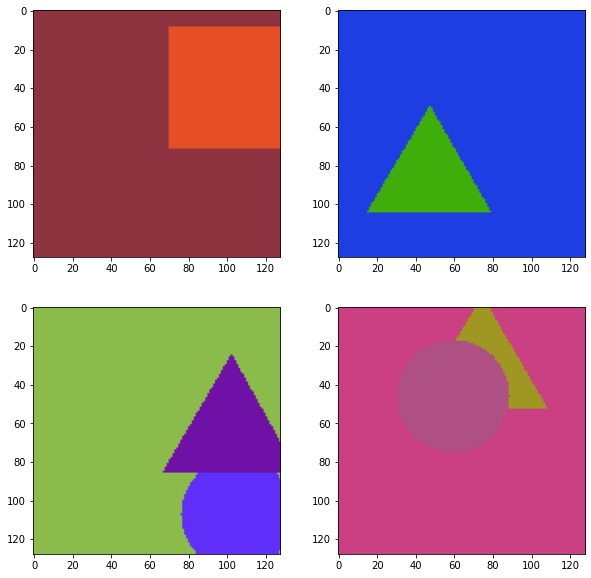

In [5]:
vis(sample)

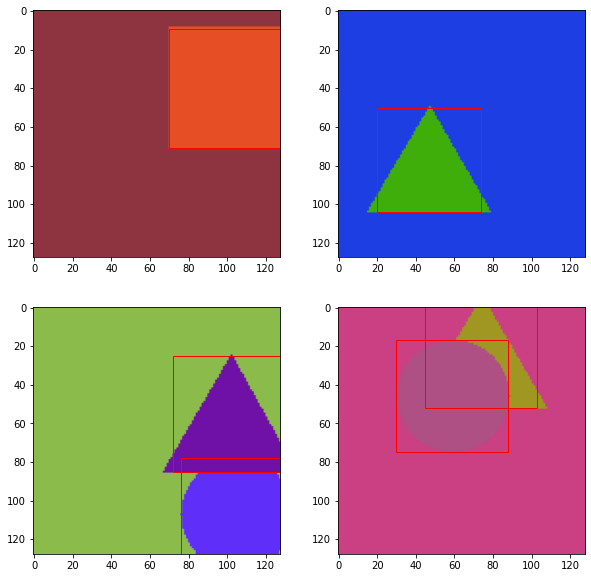

In [6]:
visDet(sample, target)

### Target Data for the Dataset

The labels/targets of the datset have 2 types of data for each image. 

1. The bounding boxes which is a tensor of size (N x 4).
here is N is the number of objects in the image and 4 correspond to:

    a. top left x coordinate
    b. top left y coordinate
    c. bottom right x coordinate
    d. bottom right y coordinate

2. The second type of targets are the classification labels of size Nx1. Here N corresponds to the number of objects in the image and the 1 corresponds to the label of the object (whether it is a triangle, square or circle).


In [7]:
print(target[0])

{'bounding_box': tensor([[ 70,   9, 132,  71]]), 'labels': tensor([1], dtype=torch.int32)}


### Converting Target Data to Ground Truth 

Here we assign bounding boxes to the various anchor boxes in our image. Anchor boxes are rectangular chunks in the image and are spread all across the image. In object detection, we divide the image into a large number of chunks of different sizes and specify two characteristics of that chunk:

1. Whether it has an object in it or not. This is done by measuring IOU of the chunk with the bounding boxes. If the IOU is > 0.7, we say that the chunk contains the object. If it is less than 0.3, we say the chunk only contains background. If the value is somewhere in between, we say it is a bad chunk and do not use it's contribution to the loss in our backpropogation.

2. How much should the chunk change in height, width and how much should it translate to best fit the object. These offsets are 4 values, for the height, width, center x and y coordinate. Please use the 


Anchor boxes might be explained best by this image:
![Anchor Boxes](https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png)

Now, first we create the chunks or "anchors" for our image. Since our image is 128x 128 in size. In this lab we want to use a stride of 16.  Hence, we should get 192 anchors.


### Why do we get the size 192 ?

We get the size of 192 as we have a total of 192 anchors in an image of 128 x 128 while using a stride of 16 and we have 3 anchors in each position of the image. 

Let's break this down.

128/16 = 8.

Hence, our neural network should output a feature map of 8 x 8 in spatial dimensions. Each grid in this feature map is an anchor position. Each position has 3 boxes/anchors of 3 shapes -> size 40x40, 50x50 and 60x60.

Hence the total anchors are 8x8x3 = 192. 

Your first job is to write the code that creates these 192 anchors from an image of size 128x128. Each anchor is represented by the top left and bottom right x,y coordinates of the anchors in regards with a 128x128 image. 

Hence, the output of the below function should be a tensor of size [192,4]


In [8]:
def get_gt_boxes():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a numpy array of size [192,4]
    """
    stride = 16 # The stride of the final feature map is 16 (the model compresses the image from 128 x 128 to 8 x 8)
    map_sz = 128 # this is the length of height/width of the image

    scales = torch.tensor([40,50,60])
    ratios = torch.tensor([[1,1]]).view(1,2)
    
    gt_boxes = []
    # TODO
    for i in range(0, map_sz//stride):
        for j in range(0, map_sz//stride):
            for scale in scales:
                top_left_x = (i * stride + stride//2) - scale//2
                top_left_y = (j * stride + stride//2) - scale//2
                bottom_right_x = (i * stride + stride//2) + scale//2
                bottom_right_y = (j * stride + stride//2) + scale//2
                temp = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
                # temp = torch.tensor([max(0,t) for t in temp])  # I'm not sure if we shold process here, I tried two version, seems we process here can get better result
                # print(temp[3] - temp[1])
                temp = torch.tensor([t for t in temp])
                gt_boxes.append(temp)
                # print(temp)
    gt_boxes = torch.stack(gt_boxes)
    return gt_boxes

gt_boxes = get_gt_boxes()

assert gt_boxes.size() == (192,4)

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


# A Pictoral Representation of our Model

![alt text](https://cdn-images-1.medium.com/max/1600/1*7heX-no7cdqllky-GwGBfQ.png)


However instead of $2k$ in the given image we just have k scores. We group triangles, squares and circles into one foreground class for this demo. Of course, we can have seperate predictions for each class but that is added complexity and is not implemented here.


Your next job is to construct the model. Most parts of the model is already constructed, your job is to add the classification and bounding box regression heads to the encoder.

In [26]:
class ShapesModel(nn.Module):

    def __init__(self):
        super(ShapesModel, self).__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 18 encoder
        self.encoder = ResnetEncoder(num_layers=18, pretrained=False)

        # a small conv net
        self.conv = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1
        )

        # TODO: Add a Convolutional Layer to prediction the class predictions. This is a head that predicts whether a chunk/anchor contains an object or not.
        self.cls_logits =  nn.Conv2d(256, 3, kernel_size=1)

        # TODO: Add a Convolutional Layer to prediction the class predictions. This is a head that regresses over the 4 bounding box offsets for each anchor
        self.bbox_pred = nn.Conv2d(256, 12, kernel_size=1)
    
    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function
        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)
        return layer
    
    def get_predict_regressions(self, cls_pred, box_pred):
        # helper function that gets outputs in the right shape for applying the loss
        N, AxC, H, W = cls_pred.shape
        Ax4 = box_pred.shape[1]
        A = Ax4 // 4
        C = AxC // A
        cls_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )
        
        box_pred = self.permute_and_flatten(
            box_pred, N, A, 4, H, W
        )
        return cls_pred, box_pred

    def forward(self, x):
        # x.size() == (1, 3, 128, 128)
        bt_sz = x.size(0)
        x = self.encoder(x)[3]
        x = F.relu(self.conv(x))
        # print(x.shape)
        # x.size() == (1, 256, 8, 8)
        cls_pred = self.cls_logits(x)
        # print(cls_pred.shape)
        # cls_pred.size() == (1, 3, 8, 8)
        box_pred = self.bbox_pred(x)
        # print(box_pred.shape)
        # box_pred.size() == (1, 12, 8, 8)
        cls_pred, box_pred = self.get_predict_regressions(cls_pred, box_pred)
        
        # cls_pred.size() == (1, 192, 1)
        # box_pred.size() == (1, 192, 4)
        return cls_pred.squeeze(2), box_pred



In [24]:
m = ShapesModel()
a = torch.randn(1,3,128,128) # dummy input
cls_pred, box_pred = m(a)
print('The outputs of the net are of size: ', cls_pred.size(), box_pred.size())

assert cls_pred.size() == (1,192) and box_pred.size() == (1,192,4)

The outputs of the net are of size:  torch.Size([1, 192]) torch.Size([1, 192, 4])


Each anchor is represented by the top left and bottom right x,y coordinates of the anchors in regards with a 128x128 image. 

Next we have to assign a class label to each anchor and in case the anchor has an IOU > 0.7 with any real object assign 4 offsets to the anchor. We do this for every single image. Each image would have it's own set of anchors with different class probabilities and offsets as that depends on what objects are situated in that image. 

Your job is to calculate those values. Fill out the below function. Hint: Use the `box_iou` and `get_offsets` function.

In [12]:
def get_bbox_gt(ex_boxes, gt_boxes, sz=128):
    '''
    
    INPUT:
    ex_boxes: [Nx4]: Bounding boxes in the image. Here N is the number of bounding boxes the image has
    gt_boxes: [192 x 4]: Anchor boxes of an image of size 128 x 128 with stride 16. 
    sz : 128
    OUTPUT: 
    gt_classes: [192 x 1] : Class labels for each anchor: 1 is for foreground, 0 is for background and -1 is for a bad anchor. [where IOU is between 0.3 and 0.7]
    gt_offsets: [192 x 4]: Offsets for anchor to best fit the bounding box object. 0 values for 0 and -1 class anchors.
    '''
    ex_boxes = ex_boxes.cpu()
    gt_boxes = gt_boxes.cpu()
    N = gt_boxes.shape[0]
    M = ex_boxes.shape[0]
    # gt_classes = []
    gt_offsets = torch.zeros(N, 4)
    high_threshold = 0.7
    low_threshold = 0.3
    def iou_fun(iou_val):
        if iou_val > 0.7:
            return 1
        elif iou_val > 0.3:
            return -1
        else:
            return 0
    def label_fun(iou_vec):
        if any(iou_vec == 1):
            # print(iou_vec, any(iou_vec))
            return 1
        elif any(iou_vec== -1):
            return -1
        else:
            return 0
        

    # print(gt_boxes.shape, ex_boxes.shape)
    iou_res = box_iou(gt_boxes, ex_boxes)
    assert(iou_res.shape == (N, M))
    gt_classes = iou_res.apply_(iou_fun).long()

    for i,j in (gt_classes == 1).nonzero():
        t = get_offsets(gt_boxes[i].unsqueeze(dim = 0), ex_boxes[j].unsqueeze(dim = 0)).squeeze()
        gt_offsets[i] = t
    gt_classes = torch.Tensor([label_fun(i) for i in gt_classes]).unsqueeze(dim = 1)
    # print(gt_offsets)
    assert(gt_classes.shape == (N, 1))
    assert(gt_offsets.shape == (N, 4))
    return gt_classes, gt_offsets

In [13]:
def get_targets(target, sample):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''

    batched_preds = []
    batched_offsets = []
    final_cls_targets = []
    final_box_offsets = []
    for t, s in zip(target, sample):
        bboxes = t['bounding_box'].to(device).float()
        class_targets, box_offsets = get_bbox_gt(bboxes, gt_boxes, sz=128)
        final_cls_targets.append(class_targets)
        final_box_offsets.append(box_offsets)
    
    final_cls_targets = torch.stack(final_cls_targets, dim=0)
    final_box_offsets = torch.stack(final_box_offsets, dim=0)

    return final_cls_targets, final_box_offsets

out_pred, out_box = model(ims)This is the meat of object detection right there ! The correct calculation of the anchors for an image and it's ground truth. Now that this is done, we can move on to our neural network training code.

In [14]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

for t, s in zip(target, sample):
    device = "cpu"
    bboxes = t['bounding_box'].to(device).float()
    gt_boxes = gt_boxes.to(device)
    class_targets, box_offsets = get_bbox_gt(bboxes, gt_boxes, sz=128)

## Tring to Reweight
We try to reweight sample, but result is not good

In [17]:
for i, (ims, targets) in enumerate(trainloader):
    break
class_targets, box_targets = get_targets(targets, ims)
class_targets = class_targets.squeeze()
positive_index = class_targets.nonzero(as_tuple=True)
positive_number = (class_targets==1).nonzero().size()[0]
negative_number = class_targets.shape[0] * class_targets.shape[1] - positive_number
weight = torch.ones_like(class_targets)
weight[positive_index] = positive_number/negative_number
print(positive_number, negative_number)

79 6065


## Loss Function

One more small kink in the puzzle of object detection is the way the classification loss is calculated. Here, the classification loss is the binary cross entropy loss. The loss is calculated only for those anchors which are background and foreground anchors NOT the negative ones. 

One more kink in this setup is that we should sample background and foreground anchors in the ratio of 3:1. This is because there are too many background anchors and the model will predict a background anchor for every anchor and still get a 90% accuracy on the classification. To prevent this, we do this sampling which is also called hard online negative sampling. However, as we have a very small amount of anchors here (192) this isn't a problem. However, for smaller strides and different scales and ratios for each position, thie number can balloon to upto 100,000. Hence, implementing hard online negative sampling is left to be optional to you.

For the bounding box regressions, use a Smooth L1 loss, this works well and prevents outliers.

Your next task is to write the code for the class_loss and bbox_loss. The classification loss should be applied to all positive (containing an object) and negative anchors (does not contain an object). The loss should not be calculated for the anchors whose IOU values are between 0.7 and 0.3.

Apply a Smooth L1 loss to regress on the bounding box offsets, (only apply this loss for anchors which contain an object !)

**Extra Credit**: Implement Hard Online Negative Sampling, however it is not necessasary. You can get this model to train without using it as the number of anchors are low for an image in this case.



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## model debug

In [28]:
model = ShapesModel().cuda()
for i, (ims, targets) in enumerate(trainloader):
    break
# print(ims.shape)
device = "cuda:0"
ims = torch.stack(list(ims), dim=0).to(device)

class_targets, box_targets = get_targets(targets, ims)
class_targets = class_targets.squeeze()
out_pred, out_box = model(ims)

## Loss Define

We tried two type loss here: Focal loss and BCE

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            criterion = nn.BCEWithLogitsLoss(reduction="none")
            BCE_loss = criterion(inputs, targets)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [68]:
def class_loss(out_pred, class_targets, loss_type="BCE", weight=None, sampling_mask=None):
    if loss_type == "focal_loss":
        class_targets = class_targets.cuda()
        focal_loss = FocalLoss(gamma=2, alpha=0.25)
        mask = torch.zeros_like(class_targets.cuda())
        mask[(class_targets >= 0).nonzero(as_tuple=True)] = 1
        criterion = focal_loss
        out_pred = out_pred.mul(mask)
        class_targets = class_targets.mul(mask)
        sigmoid = nn.Sigmoid()
        # logit = torch.stack([1 - sigmoid(out_pred), sigmoid(out_pred)], dim=2)
        # logit = logit.reshape(-1, 2).cuda()
        # class_targets = class_targets.reshape(-1)
        # loss = criterion(logit, class_targets.long())
        loss = criterion(out_pred, class_targets)
    elif loss_type == "BCE":
        class_targets = class_targets.cuda()
        mask = torch.zeros_like(class_targets.cuda())
        mask[(class_targets >= 0).nonzero(as_tuple=True)] = 1
        if weight is not None:
            criterion = nn.BCEWithLogitsLoss(weight=weight)
        else:
            if sampling_mask is not None:
                criterion = nn.BCEWithLogitsLoss(reduction="none")
            else:
                criterion = nn.BCEWithLogitsLoss()
        out_pred = out_pred.mul(mask)
        class_targets = class_targets.mul(mask)
        sigmoid = nn.Sigmoid()
        loss = criterion(out_pred, class_targets)
        if sampling_mask is not None:
            loss = loss.mul(sampling_mask)
            loss = loss.mean()
    return loss

def bbox_loss(out_bbox, box_targets, class_targets):
    print(class_targets.shape)
    mask = torch.zeros_like(class_targets.cuda())
    mask[(class_targets == 1).nonzero(as_tuple=True)] = 1
    criterion = nn.SmoothL1Loss(reduction='none')
    loss = criterion(out_bbox.cuda(), box_targets.cuda()).mean(dim = 2).mul(mask).mean()
    return loss

## Training Function. 

This is the training function, you do not need to change any code here. You can add a validation function here to verify that your model is working well. However, you do not need to submit it.

**notice**: we notice the loss = loss_cls + loss_bbox, loss for cls and regression are at different scale, we use a hyperparameter bebore loss_bbox

## Negative Sampling (via mask)
We statistic the positive sample in each batch, and shuffle the negative index to get the kept and dropped part. Finally, we generate a mask which applied to loss, the dropped part will have zero loss(only for negative samples, label = 0)

In [65]:
from torchmetrics import ConfusionMatrix
def train(ep, model, trainloader, optimizer, loss_type="BCE"):
    total_loss = 0
    b_loss = 0
    c_loss = 0
    confmat = ConfusionMatrix(num_classes=2)
    for i, (ims, targets) in enumerate(trainloader):
        ims = torch.stack(list(ims), dim=0).to(device)
        class_targets, box_targets = get_targets(targets, ims)
        class_targets = class_targets.squeeze()
        
        
        positive_index = (class_targets==1).nonzero(as_tuple=True)
        negative_index = (class_targets==0).nonzero()
        positive_number = (class_targets==1).nonzero().size()[0]
        negative_number = class_targets.shape[0] * class_targets.shape[1] - positive_number

        a = negative_index
        a = a[torch.randperm(a.size()[0])]
        kept_neg = a[:positive_number]
        masked_neg = a[positive_number:]
        sampling_mask = torch.ones_like(class_targets).to(device)
        masked_neg = tuple(masked_neg.T)
        # print(masked_neg)
        sampling_mask[masked_neg] = 0

        out_pred, out_box = model(ims)
        loss_cls = class_loss(out_pred, class_targets, loss_type=loss_type, sampling_mask=sampling_mask)
        loss_bbox = bbox_loss(out_box, box_targets, class_targets)
        # confmat(out_pred, target)
        # loss_bbox = 0
        lamda = 1
        loss = loss_cls + lamda * loss_bbox
        sigmoid = nn.Sigmoid()
        print((sigmoid(out_pred) > 0.7).nonzero())


        if loss.item() != 0:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        c_loss += loss_cls.item()
        b_loss += loss_bbox.item()
        print(total_loss / (i+1), c_loss / (i+1), b_loss / (i+1))
        

    avg_c_loss = float(c_loss / len(trainloader))
    avg_b_loss = float(b_loss / len(trainloader))
    torch.save(model, "./cached_models/mask_lr_0.1_lamda1_"+str(ep))
    print('Trained Epoch: {} | Avg Classification Loss: {}, Bounding loss: {}'.format(ep, avg_c_loss, avg_b_loss))

**I train model locally on my GPU**

In [42]:
# device = "cuda"
model = ShapesModel().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
start_epoch = 0
train_epoch = 20
loss_type = "BCE"
for ep in range(start_epoch, start_epoch + train_epoch):
    train(ep, model, trainloader, optimizer, loss_type)

torch.Size([32, 192])
tensor([[28, 77]], device='cuda:0')
0.6867152452468872 0.6861342191696167 0.0005809967406094074
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.5075986385345459 0.5068668723106384 0.000731745851226151
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.41794194281101227 0.41681726773579914 0.0011246622695277135
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.36617564409971237 0.36476704105734825 0.0014085930888541043
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.3551089406013489 0.35334515273571016 0.001763777807354927
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.35150250792503357 0.34967444588740665 0.001828053966164589
torch.Size([32, 192])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
0.34600159525871277 0.3443288483789989 0.0016727405600249767
torch.Size([32, 192])
ten

KeyboardInterrupt: 

We can observe that 0.6861342191696167 0.0005809967406094074, the cls loss and regression loss do not share the same scale, thus I tried to reweight the loss (by giving loss_cls + lambda * loss_bbox), however, the optimization becomes unstable. 
For simple model, I guess simply reweight can make model less stable

### Now let's visualize the predictions !

The most exciting part of any neural network model setup. First let's visualize our ground truth.

In [61]:
sample, target = iter(valloader).next()
sample = torch.stack(sample,dim=0)
sample = sample.cuda()

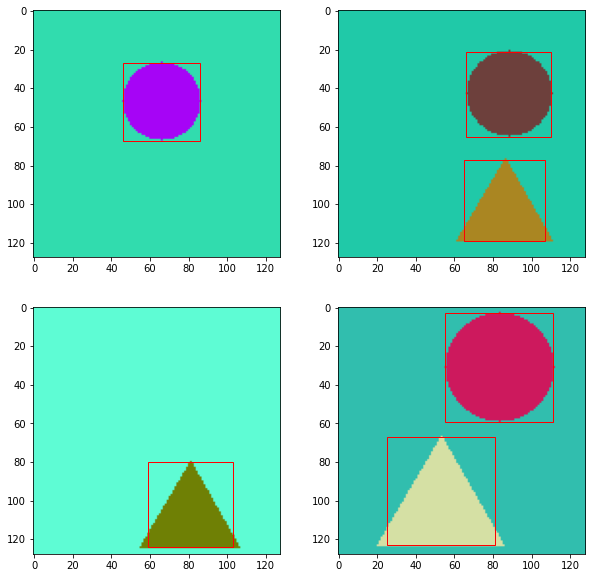

In [62]:
visDet(sample.cpu(), target)
sample = sample.cuda()

### Our Model Predictions

Note: We perform NMS upon our final predictions to clear up the output. This is done as a lot of anchors near to the actual object will fire resulting in a lot of boxes. NMS handles these multiple predictions by merging and giving a single box for a predicted object instead of multiple. This is best signified through another image:

![NMS](https://miro.medium.com/max/1000/0*WI5_K3bAbYaRyzE-.png)

Now onto our model predictions !

Your final task is to write code to visualize the model predictions on an image in the validation set. You can use the `visDet` function to help out with visualizing. Your main job would be to select what anchors (after applying offsets) to draw on the image. Generally, if the probability is > 0.7. It's a good idea to use the anchor. Also, you can use the `nms` function inside `boxes.py`.


In [59]:
def inverse(gt_boxes, offsets):
    gt_boxes += (offsets[0] * offsets[2])
    return gt_boxes
# inverse(gt_boxes, get_offsets(gt_boxes, ex_boxes))

In [60]:
sample.shape

torch.Size([32, 3, 128, 128])

In [48]:
def apply_offsets(gt_boxes, box_offsets):
    gt_width = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_height = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_center_x = gt_boxes[:, 0] + 0.5*gt_width
    gt_center_y = gt_boxes[:, 1] + 0.5*gt_height

    index = box_offsets.nonzero(as_tuple=True)
    # delta_x = (gt_center_x - ex_center_x) / ex_width
    # delta_y = (gt_center_y - ex_center_y) / ex_height
    # delta_scaleX = torch.log(gt_width / ex_width)
    # delta_scaleY = torch.log(gt_height / ex_height)
    delta_x = box_offsets[:, 0]
    delta_y = box_offsets[:, 1]
    delta_scaleX = box_offsets[:, 2]
    delta_scaleY = box_offsets[:, 3]

    ex_width = gt_width / torch.exp(delta_scaleX)
    ex_height = gt_height / torch.exp(delta_scaleX)
    ex_center_x = gt_center_x - delta_x * ex_width
    ex_center_y = gt_center_y - delta_y * ex_height


    top_left_x = (ex_center_x) - ex_width//2
    top_left_y = (ex_center_y) - ex_height//2
    bottom_right_x = (ex_center_x) + ex_width//2
    bottom_right_y = (ex_center_y) + ex_height//2
    temp = torch.stack([top_left_x, top_left_y, bottom_right_x, bottom_right_y], dim=1)
    res = torch.zeros_like(temp)
    res[index] = temp[index]
    return res



def apply_offset_single_box(gt_boxes, box_offsets):
    gt_width = gt_boxes[2] - gt_boxes[0]
    gt_height = gt_boxes[3] - gt_boxes[1]
    gt_center_x = gt_boxes[0] + 0.5*gt_width
    gt_center_y = gt_boxes[1] + 0.5*gt_height

    index = box_offsets.nonzero(as_tuple=True)
    # delta_x = (gt_center_x - ex_center_x) / ex_width
    # delta_y = (gt_center_y - ex_center_y) / ex_height
    # delta_scaleX = torch.log(gt_width / ex_width)
    # delta_scaleY = torch.log(gt_height / ex_height)
    delta_x = box_offsets[0]
    delta_y = box_offsets[1]
    delta_scaleX = box_offsets[2]
    delta_scaleY = box_offsets[3]

    ex_width = gt_width / torch.exp(delta_scaleX)
    ex_height = gt_height / torch.exp(delta_scaleX)
    ex_center_x = gt_center_x - delta_x * ex_width
    ex_center_y = gt_center_y - delta_y * ex_height


    top_left_x = (ex_center_x) - ex_width//2
    top_left_y = (ex_center_y) - ex_height//2
    bottom_right_x = (ex_center_x) + ex_width//2
    bottom_right_y = (ex_center_y) + ex_height//2
    # print(top_left_x)
    res = torch.Tensor([top_left_x, top_left_y, bottom_right_x, bottom_right_y]).cuda()
    return res

## Reverse
Here We use reverse_single_box

reverse_single_box(single_box, get_single_offset(single_box, target)) == single_box

In [49]:
def reverse_single_box(gt_box, offset):
    ex_box = apply_offset_single_box(gt_box, offset)
    return ex_box

e_box = gt_boxes[0] + torch.Tensor([1,2,3,4])
e_box = e_box
offset = get_offsets(gt_boxes[0].unsqueeze(0), e_box.unsqueeze(0)).squeeze()
res = reverse_single_box(gt_boxes[0], offset)

assert all(res.cpu() == e_box)

In [77]:
def visPred(model, sample):
    #TODO: visualize your model predictions on the sample image.
    out_pred, out_box = model(sample)
    
    gt_boxes = get_gt_boxes()
    gt_boxes = gt_boxes.cuda()
    
    # offsetted_box = apply_offsets(gt_boxes, out_box)
    
    sigmoid = nn.Sigmoid()
    index = (sigmoid(out_pred)>0.7).nonzero()
    # print(index)
    selected_boxes_index = (sigmoid(out_pred)>0.7).nonzero(as_tuple=True)
    selected_offsets = out_box[selected_boxes_index]
    # selected_offsets
    
    batched_boxes = [[] for _ in range(32)]
    batched_scores = [[] for _ in range(32)]
    
    batch_size = 32
    count = 0
    for i,j in index:
        offset = selected_offsets[count]
        box = gt_boxes[j]
        offsetted_box = reverse_single_box(box, offset)
        # print(offset)
        # print(offsetted_box)
        batched_boxes[i].append(offsetted_box)
        batched_scores[i].append(sigmoid(out_pred)[i][j])
        count = count + 1
    # print((sigmoid(out_pred)>0.5).nonzero())
    for i in range(batch_size):
        if len(batched_boxes[i]) == 0:
            # batched_boxes[i] = boxes[kept_index]
            # batched_scores[i] = scores[kept_index]
            continue
        boxes = torch.stack(batched_boxes[i])
        scores =  torch.stack(batched_scores[i])
        kept_index = nms(boxes, scores, iou_threshold=0.1)
        batched_boxes[i] = boxes[kept_index]
        batched_scores[i] = scores[kept_index]
    # 
    
    sample = sample.cpu()
    show_sample = sample.permute(0,2,3,1)
    fig, axs = plt.subplots(2,2)

    axs[0,0].imshow(show_sample[0])
    for t in batched_boxes[0]:
        draw_box(axs[0,0], t.detach().cpu())

    axs[0,1].imshow(show_sample[1])
    for t in batched_boxes[1]:
        draw_box(axs[0,1], t.detach().cpu())

    axs[1,0].imshow(show_sample[2])
    for t in batched_boxes[2]:
        draw_box(axs[1,0], t.detach().cpu())

    axs[1,1].imshow(show_sample[3])
    for t in batched_boxes[3]:
        draw_box(axs[1,1], t.detach().cpu())

## Baseline Performance

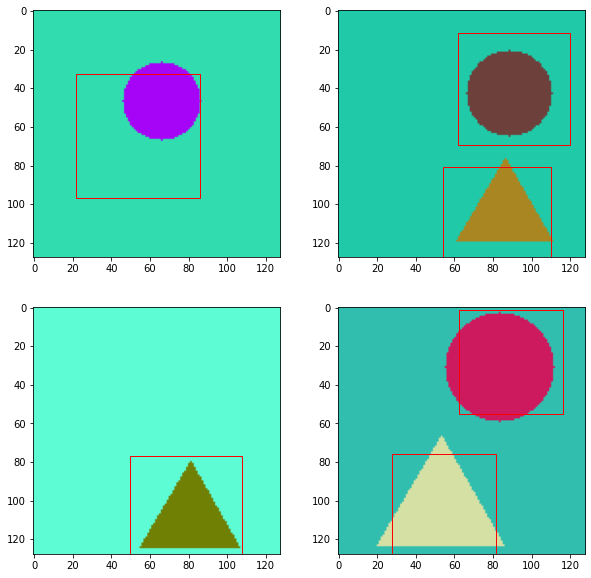

In [80]:
model = torch.load("../cached_models/retrain_without_process/retrain5")
visPred(model, sample)

## Negative sampling performance

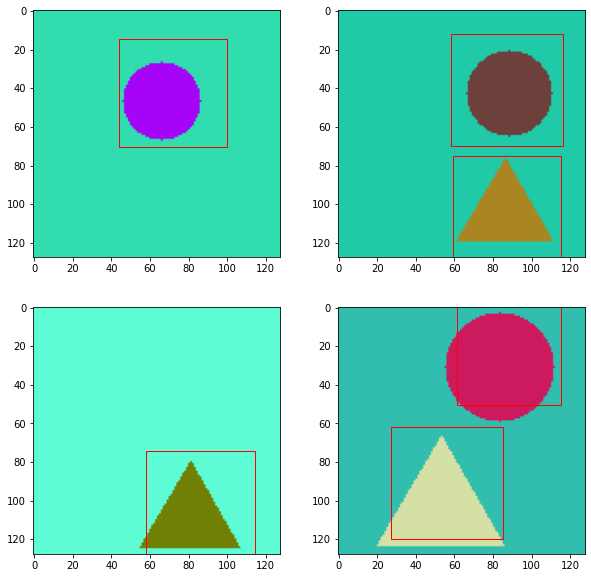

In [96]:
model = torch.load("../cached_models/mask_lr_0.1_lamda1_15")
visPred(model, sample)

## reweight performance(unstable optimization!)

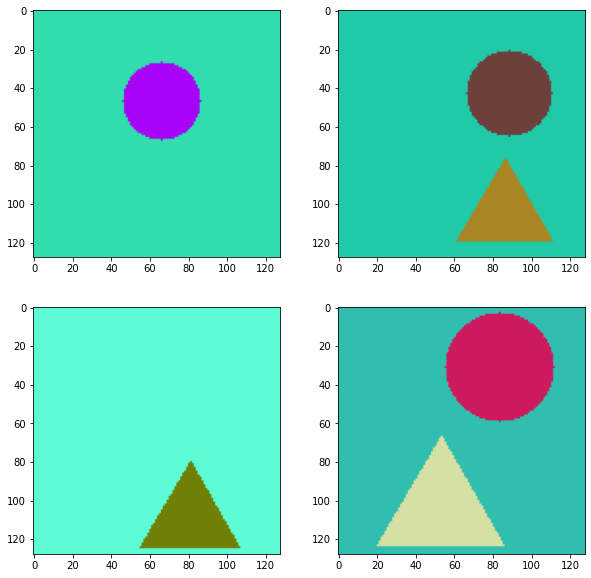

In [81]:
model = torch.load("../cached_models/reweight_lr_0.01_lamda1_19")
visPred(model, sample)

## Conclusion

Not bad, right ? This is a very barebones implementation and trained for a very short amount of epochs. However this is the meat and bones of most anchor based state of the art detectors out today. We can improve accuracy by doing multiscale training by incorporating a Feature Pyramid Network but that is for you to discover :') 

## References

Some foundational/good papers on object detection. This list is non exhaustive

1. [Single Shot Detector](https://arxiv.org/abs/1512.02325)
2. [YOLO](https://arxiv.org/abs/1612.08242)
3. [Faster RCNN](https://arxiv.org/abs/1506.01497)
4. [Feature Pyramid Network](https://arxiv.org/abs/1612.03144)
5. Bonus Read: [DETR- State of the art Object detector based on Transformers](https://arxiv.org/abs/2005.12872)


For the simple task, the highly trained model just like FasterRCNN is overkilled.
But the interesting observation is subsampling can get better performance than simply reweighting those minority/tail examples. Such observation is coincidental with the general empirical observation: resampling leads to overfit and reweight leads to unstable optimization.

Here, our simple model regulized the overfit possibility.